**1. Import Library**

In [ ]:
%pip install boruta
%pip install imblearn
%pip install shap
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import shap
import optuna
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Pre-Processing Data**


*   Load Data




In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/merged_dataset_saya_setelah_rename.csv')

* Inspeksi awal

In [ ]:
df.shape
print("Jumlah baris dan kolom:", df.shape)

Jumlah baris dan kolom: (827658, 41)


In [ ]:
df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.000000,0.00,0.0,...,84,578,563.26,84.239991,563.26,0.000251,100,7.096376e+03,Mirai,Mirai_Greip_Flood
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.000000,0.00,0.0,...,98,578,573.20,48.000000,573.20,0.000195,100,2.304000e+03,Mirai,Mirai_Greip_Flood
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.000000,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000363,100,0.000000e+00,Mirai,Mirai_Greip_Flood
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.000000,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000074,100,0.000000e+00,Mirai,Mirai_Greip_Flood
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.000000,0.01,0.0,...,74,590,563.09,75.596763,563.09,0.000408,100,5.714871e+03,Mirai,Mirai_Greip_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827653,32.00,6,208.00,1437.192982,0.0,0.00,0.0,0.600000,1.00,0.0,...,66,2922,1550.90,870.699393,1550.90,0.000696,10,7.581174e+05,Web Based,Browser_Hijacking
827654,32.00,6,154.00,1047.031628,0.0,0.00,0.0,0.500000,1.00,0.0,...,66,2922,1494.00,1505.244166,1494.00,0.000955,10,2.265760e+06,Web Based,Browser_Hijacking
827655,32.00,6,244.00,1541.116990,0.0,0.00,0.0,0.800000,1.00,0.0,...,1494,2922,2636.40,602.097666,2636.40,0.000821,10,3.625216e+05,Web Based,Browser_Hijacking
827656,32.00,6,244.00,5066.196401,0.0,0.00,0.0,0.600000,1.00,0.0,...,1494,4350,2564.10,1224.308825,2564.10,0.000198,10,1.498932e+06,Web Based,Browser_Hijacking


In [ ]:
df.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
0,0.24,47,64.00,3988.838908,0.0,0.00,0.0,0.0,0.00,0.0,...,84,578,563.26,84.239991,563.26,0.000251,100,7096.376162,Mirai,Mirai_Greip_Flood
1,0.00,47,64.00,5156.508483,0.0,0.00,0.0,0.0,0.00,0.0,...,98,578,573.20,48.000000,573.20,0.000195,100,2304.000000,Mirai,Mirai_Greip_Flood
2,0.00,47,64.00,2756.635755,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000363,100,0.000000,Mirai,Mirai_Greip_Flood
3,0.00,47,64.00,13734.704303,0.0,0.00,0.0,0.0,0.00,0.0,...,578,578,578.00,0.000000,578.00,0.000074,100,0.000000,Mirai,Mirai_Greip_Flood
4,0.64,47,65.79,2448.342206,0.0,0.01,0.0,0.0,0.01,0.0,...,74,590,563.09,75.596763,563.09,0.000408,100,5714.870606,Mirai,Mirai_Greip_Flood


In [ ]:
df.tail()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
827653,32.0,6,208.0,1437.192982,0.0,0.0,0.0,0.600000,1.0,0.0,...,66,2922,1550.9,870.699393,1550.9,0.000696,10,7.581174e+05,Web Based,Browser_Hijacking
827654,32.0,6,154.0,1047.031628,0.0,0.0,0.0,0.500000,1.0,0.0,...,66,2922,1494.0,1505.244166,1494.0,0.000955,10,2.265760e+06,Web Based,Browser_Hijacking
827655,32.0,6,244.0,1541.116990,0.0,0.0,0.0,0.800000,1.0,0.0,...,1494,2922,2636.4,602.097666,2636.4,0.000821,10,3.625216e+05,Web Based,Browser_Hijacking
827656,32.0,6,244.0,5066.196401,0.0,0.0,0.0,0.600000,1.0,0.0,...,1494,4350,2564.1,1224.308825,2564.1,0.000198,10,1.498932e+06,Web Based,Browser_Hijacking
827657,32.0,6,244.0,5406.026146,0.0,0.0,0.0,0.571429,1.0,0.0,...,1494,4350,2718.0,1284.822167,2718.0,0.000232,7,1.650768e+06,Web Based,Browser_Hijacking


In [ ]:
df.columns

Index(['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ece_flag_number',
       'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count',
       'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP',
       'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max',
       'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'category',
       'label'],
      dtype='object')

**3. Data Cleaning**

* Cek missing/null values (apakah ada nilai kosong)


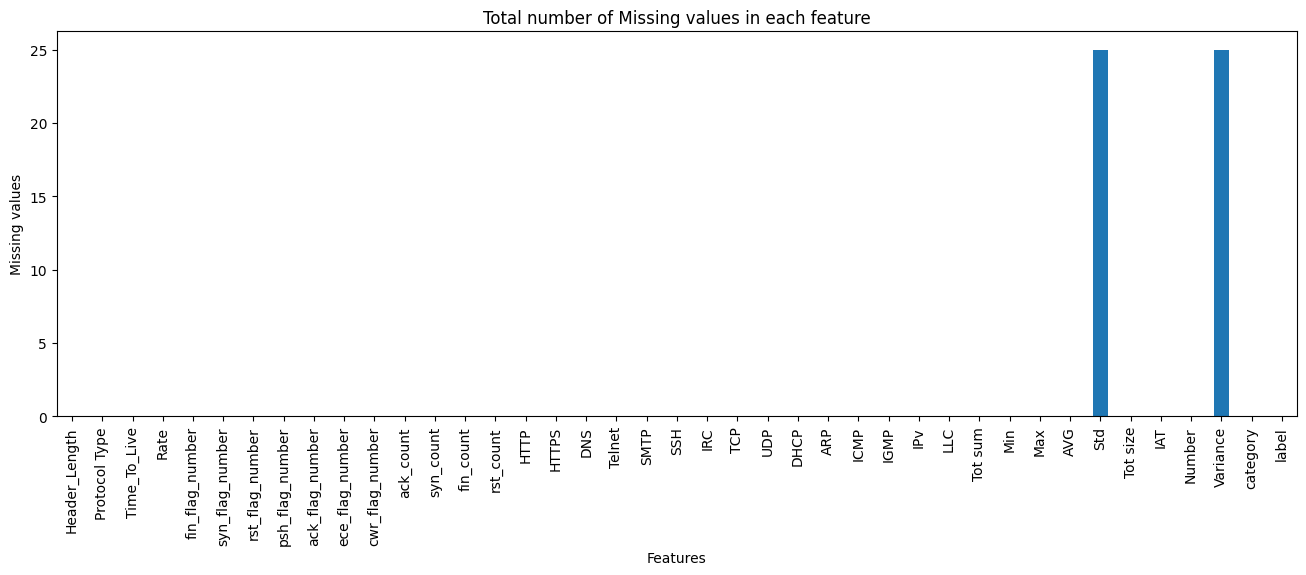

In [ ]:
def plotMissingValues(df):
    missing_values = df.isnull().sum()  # Counting null values for each column
    fig = plt.figure(figsize=(16, 5))
    missing_values.plot(kind='bar')
    plt.xlabel("Features")
    plt.ylabel("Missing values")
    plt.title("Total number of Missing values in each feature")
    plt.show()

plotMissingValues(df)


In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # hanya tampilkan kolom yang ada null-nya

Std         25
Variance    25
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827658 entries, 0 to 827657
Data columns (total 41 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    827658 non-null  float64
 1   Protocol Type    827658 non-null  int64  
 2   Time_To_Live     827658 non-null  float64
 3   Rate             827658 non-null  float64
 4   fin_flag_number  827658 non-null  float64
 5   syn_flag_number  827658 non-null  float64
 6   rst_flag_number  827658 non-null  float64
 7   psh_flag_number  827658 non-null  float64
 8   ack_flag_number  827658 non-null  float64
 9   ece_flag_number  827658 non-null  float64
 10  cwr_flag_number  827658 non-null  float64
 11  ack_count        827658 non-null  int64  
 12  syn_count        827658 non-null  int64  
 13  fin_count        827658 non-null  int64  
 14  rst_count        827658 non-null  int64  
 15  HTTP             827658 non-null  float64
 16  HTTPS            827658 non-null  floa

In [ ]:
df = df.dropna() #Hapus 25 baris

* Cek Duplicate Value

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Jumlah baris duplikat: {num_duplicates}")

Jumlah baris duplikat: 83381


In [ ]:
df[df.duplicated()].head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label
3534,0.0,47,64.0,10952.901238,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000091,100,0.0,Mirai,Mirai_Greip_Flood
4133,0.0,47,64.0,9342.266572,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000107,100,0.0,Mirai,Mirai_Greip_Flood
7726,0.0,47,64.0,11007.227398,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000091,100,0.0,Mirai,Mirai_Greip_Flood
8149,0.0,47,64.0,5049.241585,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000198,100,0.0,Mirai,Mirai_Greip_Flood
8568,0.0,47,64.0,4948.797697,0.0,0.0,0.0,0.0,0.0,0.0,...,578,578,578.0,0.0,578.0,0.000202,100,0.0,Mirai,Mirai_Greip_Flood


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (744252, 41)


In [ ]:
df[df.duplicated()].head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,category,label


* Label Encoding

In [ ]:
le = LabelEncoder() #Inisialisasi encoder

In [ ]:
df['Label_encoded'] = le.fit_transform(df['label']) #Fit dan transform label

**4. Exploratory Data Analysis (EDA)**

In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label -> Angka:")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

Mapping Label -> Angka:
Backdoor_Malware -> 0
Benign_Traffic -> 1
Browser_Hijacking -> 2
Command_Injection -> 3
DDoS_ACK_Fragmentation -> 4
DDoS_HTTP_Flood -> 5
DDoS_ICMP_Flood -> 6
DDoS_ICMP_Fragmentation -> 7
DDoS_PSHACK_Flood -> 8
DDoS_RSTFIN_Flood -> 9
DDoS_SYN_Flood -> 10
DDoS_SlowLoris -> 11
DDoS_SynonymousIP_Flood -> 12
DDoS_TCP_Flood -> 13
DDoS_UDP_Flood -> 14
DDoS_UDP_Fragmentation -> 15
DNS_Spoofing -> 16
Dictionary_Brute_Force -> 17
DoS_HTTP_Flood -> 18
DoS_SYN_Flood -> 19
DoS_TCP_Flood -> 20
DoS_UDP_Flood -> 21
MITM_Arp_Spoofing -> 22
Mirai_Greeth_Flood -> 23
Mirai_Greip_Flood -> 24
Mirai_UDPPlain -> 25
Recon_Host_Discovery -> 26
Recon_OSScan -> 27
Recon_Ping_Sweep -> 28
Recon_Port_Scan -> 29
Recon_Vulnerability_Scan -> 30
SQL_Injection -> 31
Uploading_Attack -> 32
XSS -> 33


In [ ]:
# Jumlah tiap kelas berdasarkan nama serangan
print("\nDistribusi kelas (jumlah per label):")
print(df['label'].value_counts())


Distribusi kelas (jumlah per label):
label
Benign_Traffic              33987
Recon_Vulnerability_Scan    33958
Recon_Host_Discovery        33854
Mirai_Greeth_Flood          33708
Recon_OSScan                33591
Recon_Port_Scan             33429
DNS_Spoofing                33335
DoS_HTTP_Flood              30869
MITM_Arp_Spoofing           30455
DoS_SYN_Flood               30332
DDoS_HTTP_Flood             28790
DDoS_SYN_Flood              28149
DoS_UDP_Flood               28069
DDoS_PSHACK_Flood           26811
DDoS_ICMP_Flood             26331
DDoS_TCP_Flood              25169
DoS_TCP_Flood               24876
DDoS_SynonymousIP_Flood     24864
DDoS_UDP_Flood              24620
DDoS_RSTFIN_Flood           23686
DDoS_SlowLoris              23425
DDoS_UDP_Fragmentation      23112
DDoS_ACK_Fragmentation      21939
DDoS_ICMP_Fragmentation     19858
Mirai_UDPPlain              15001
Dictionary_Brute_Force      13062
Mirai_Greip_Flood           11977
Browser_Hijacking            5788
Comm

In [ ]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
Header_Length,744252.0,18.539234,10.670905,0.000000,8.320000,20.000000,26.400000,60.0
Protocol Type,744252.0,10.112967,10.446271,0.000000,6.000000,6.000000,6.000000,47.0
Time_To_Live,744252.0,76.985511,30.990196,0.000000,64.000000,64.000000,73.900000,255.0
Rate,744252.0,inf,NaN,0.000021,339.018788,3213.619734,17098.845285,inf
fin_flag_number,744252.0,0.045471,0.179117,0.000000,0.000000,0.000000,0.000000,1.0
syn_flag_number,744252.0,0.173577,0.334824,0.000000,0.000000,0.000000,0.100000,1.0
rst_flag_number,744252.0,0.073260,0.222763,0.000000,0.000000,0.000000,0.000000,1.0
psh_flag_number,744252.0,0.122746,0.224049,0.000000,0.000000,0.000000,0.200000,1.0
ack_flag_number,744252.0,0.378920,0.405755,0.000000,0.000000,0.200000,0.800000,1.0
ece_flag_number,744252.0,0.000203,0.005646,0.000000,0.000000,0.000000,0.000000,1.0


* Visualisasi Distribusi Label Sebelum SMOTE

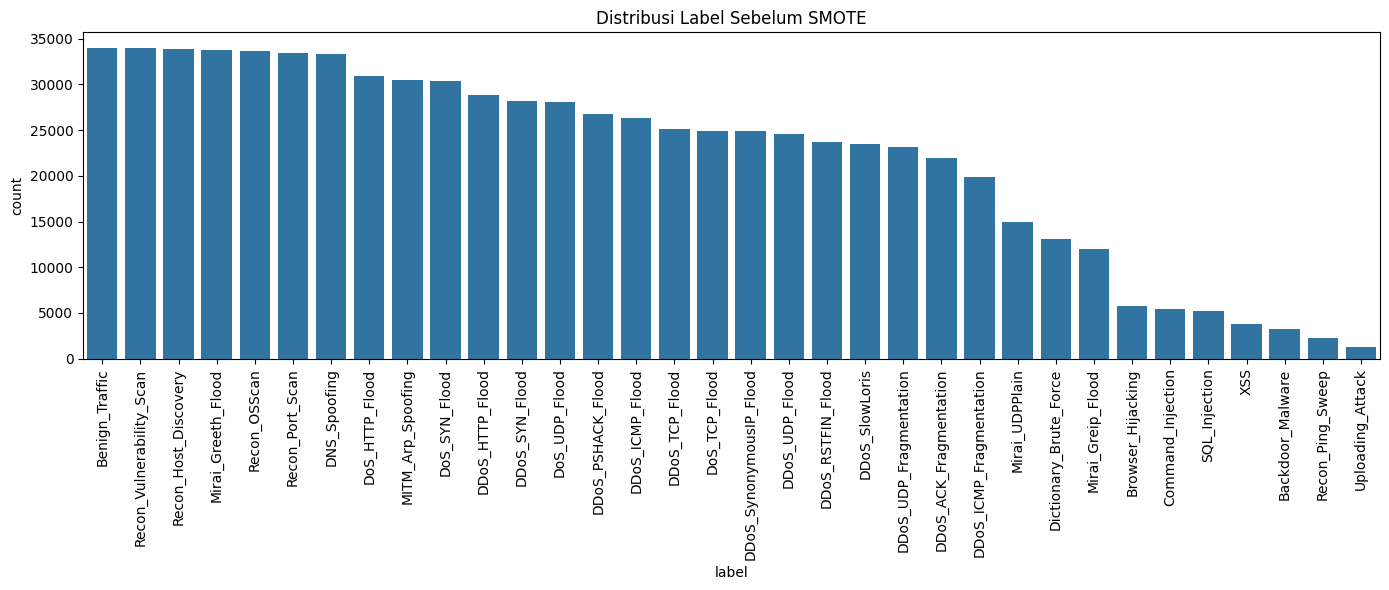

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribusi Label Sebelum SMOTE")
plt.tight_layout()
plt.show()

* Korelasi Fitur Terhadap Label Encoded

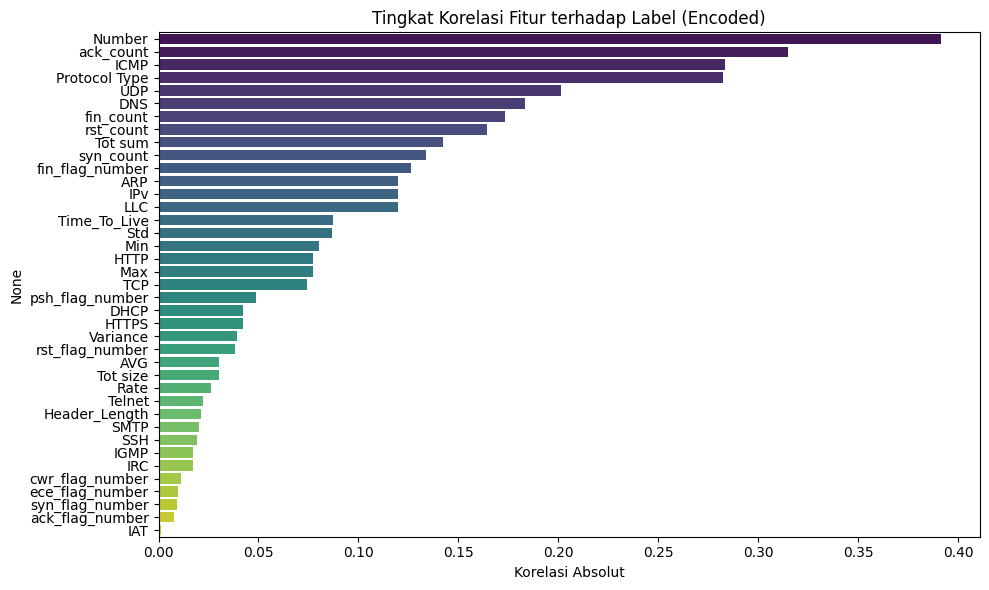

In [ ]:
corr = df.corr(numeric_only=True)
top_corr = corr['Label_encoded'].abs().sort_values(ascending=False).drop('Label_encoded').head(39)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, dodge=False, palette='viridis', legend=False)
plt.title("Tingkat Korelasi Fitur terhadap Label (Encoded)")
plt.xlabel("Korelasi Absolut")
plt.tight_layout()
plt.show()

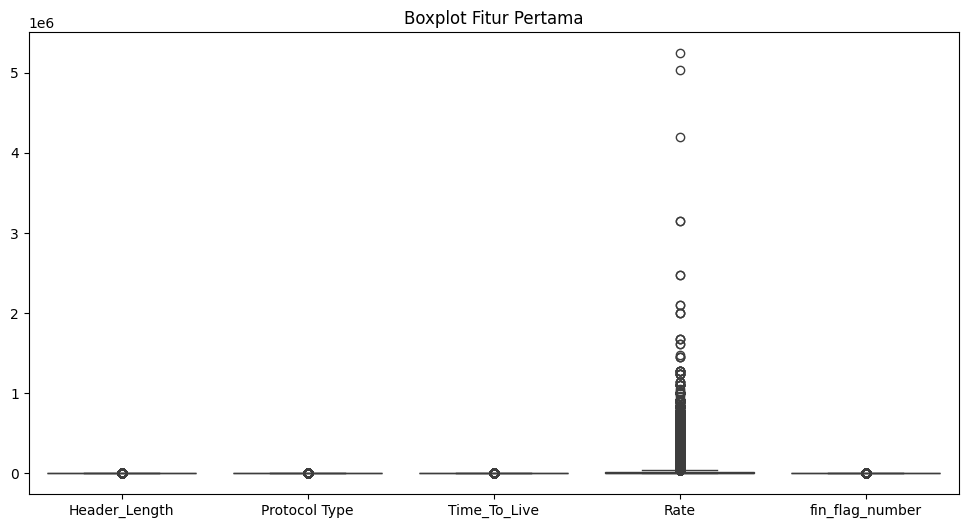

In [ ]:
# Boxplot beberapa fitur numerik (cek outlier)
plt.figure(figsize=(12,6))
sns.boxplot(data=df.iloc[:, :5])
plt.title("Boxplot Fitur Pertama")
plt.show()

**5. Pisahkan Fitur & Label**

In [ ]:
X = df.drop(["label", "category", "Label_encoded"], axis=1)
y = df["label"]

**6. Split Data**

* Train-Test-Validation Split
(70:20:10)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (520976, 39) Val: (149594, 39) Test: (73682, 39)


**7. Seleksi Fitur dengan Boruta**

* Seleksi Fitur Tahap Awal

In [ ]:
# Cek fitur dengan 1 nilai unik
constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
print("Fitur konstan:", constant_columns)

Fitur konstan: []


In [ ]:
# Hapus jika ada dari semua set data
if constant_columns:
    X_train.drop(columns=constant_columns, inplace=True)
    print(f"Fitur konstan {constant_columns} dihapus dari X_train_res.")
else:
    print("Tidak ada fitur konstan yang ditemukan.")

Tidak ada fitur konstan yang ditemukan.


In [ ]:
# Hitung korelasi
corr_matrix = X_train.corr().abs()

# Ambil korelasi di atas threshold (misal 0.98)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

print("Fitur berkorelasi tinggi:", to_drop)

Fitur berkorelasi tinggi: ['fin_count', 'IPv', 'LLC', 'Tot size']


In [ ]:
# Hapus fitur mirip/berkorelasi tinggi
X_train.drop(columns=to_drop, inplace=True)


Dengan Boruta

In [ ]:
# Check for infinite values in X_train
print("Checking for infinite values in X_train:", X_train.isin([np.inf, -np.inf]).sum().sum())

# Handle infinite values by replacing them with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that contain NaN values after replacing infinite values
X_train.dropna(inplace=True)

# Ensure y_train remains synchronized with the rows dropped from X_train
y_train = y_train[X_train.index]

print("Infinite values replaced and rows with NaN dropped from X_train.")
print("New X_train shape:", X_train.shape)
print("New y_train shape:", y_train.shape)

Checking for infinite values in X_train: 4
Infinite values replaced and rows with NaN dropped from X_train.
New X_train shape: (520972, 35)
New y_train shape: (520972,)


In [ ]:
rf_boruta = RandomForestClassifier(n_jobs=-2, class_weight="balanced", max_depth=5, random_state=42)
boruta = BorutaPy(estimator=rf_boruta, n_estimators=200, verbose=2, random_state=42)

boruta.fit(X_train.values, y_train.values)

KeyboardInterrupt: 

In [ ]:
# Pilih fitur penting
selected_features = X_train.columns[boruta.support_].to_list()
print("Fitur terpilih:", selected_features)

Fitur terpilih: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'ack_count', 'syn_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
#Simpan hasil model Boruta
joblib.dump(boruta, "/content/drive/MyDrive/Dataset/smotepakedatatraining/borutasebelumsmote_model.pkl")

#Simpan daftar fitur terpilih
np.save("/content/drive/MyDrive/Dataset/smotepakedatatraining/selected_features.npy", selected_features)

In [ ]:
# Load kembali
boruta = joblib.load("/content/drive/MyDrive/Dataset/smotepakedatatraining/borutasebelumsmote_model.pkl")

# Load fitur terpilih
selected_features = np.load("/content/drive/MyDrive/Dataset/smotepakedatatraining/selected_features.npy", allow_pickle=True).tolist()

print("Model Boruta dan fitur terpilih berhasil di-load kembali.")
print("Fitur terpilih:", selected_features)

Model Boruta dan fitur terpilih berhasil di-load kembali.
Fitur terpilih: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'ack_count', 'syn_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
print("Jumlah fitur terpilih:", len(selected_features))
print("Daftar fitur:", selected_features[:31])

Jumlah fitur terpilih: 31
Daftar fitur: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'ack_count', 'syn_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number', 'Variance']


In [ ]:
# Gunakan hanya fitur terpilih
X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

**8. SMOTE (hanya di train set)**

In [ ]:
smote = SMOTE(random_state=42) #Inisialisasi SMOTE

In [ ]:
X_train_res, y_train_res = smote.fit_resample(X_train_sel, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Sesudah SMOTE:", y_train_res.value_counts())

Sebelum SMOTE: label
Benign_Traffic              23791
Recon_Vulnerability_Scan    23771
Recon_Host_Discovery        23698
Mirai_Greeth_Flood          23596
Recon_OSScan                23514
Recon_Port_Scan             23400
DNS_Spoofing                23334
DoS_HTTP_Flood              21606
MITM_Arp_Spoofing           21318
DoS_SYN_Flood               21232
DDoS_HTTP_Flood             20153
DDoS_SYN_Flood              19704
DoS_UDP_Flood               19646
DDoS_PSHACK_Flood           18768
DDoS_ICMP_Flood             18432
DDoS_TCP_Flood              17618
DoS_TCP_Flood               17413
DDoS_SynonymousIP_Flood     17405
DDoS_UDP_Flood              17234
DDoS_RSTFIN_Flood           16580
DDoS_SlowLoris              16398
DDoS_UDP_Fragmentation      16178
DDoS_ACK_Fragmentation      15357
DDoS_ICMP_Fragmentation     13901
Mirai_UDPPlain              10501
Dictionary_Brute_Force       9143
Mirai_Greip_Flood            8384
Browser_Hijacking            4052
Command_Injection          

**9.  Hyperparameter Tuning dengan Optuna**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-2,
        class_weight="balanced"
    )
    model.fit(X_train_res, y_train_res) # Use resampled data for training
    return model.score(X_val_sel, y_val) # Evaluate on the validation set

In [ ]:
# Check and handle infinite values in X_val_sel and X_test_sel
print("Checking for infinite values in X_val_sel:", X_val_sel.isin([np.inf, -np.inf]).sum().sum())
print("Checking for infinite values in X_test_sel:", X_test_sel.isin([np.inf, -np.inf]).sum().sum())

# Handle infinite values by replacing them with NaN and dropping rows
X_val_sel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_sel.dropna(inplace=True)
y_val = y_val[X_val_sel.index] # Synchronize y_val

X_test_sel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_sel.dropna(inplace=True)
y_test = y_test[X_test_sel.index] # Synchronize y_test


print("Infinite values replaced and rows with NaN dropped from X_val_sel and X_test_sel.")
print("New X_val_sel shape:", X_val_sel.shape)
print("New y_val shape:", y_val.shape)
print("New X_test_sel shape:", X_test_sel.shape)
print("New y_test shape:", y_test.shape)

Checking for infinite values in X_val_sel: 1
Checking for infinite values in X_test_sel: 0
Infinite values replaced and rows with NaN dropped from X_val_sel and X_test_sel.
New X_val_sel shape: (149593, 31)
New y_val shape: (149593,)
New X_test_sel shape: (73682, 31)
New y_test shape: (73682,)


/tmp/ipython-input-1513663177.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_sel.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-1513663177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_sel.dropna(inplace=True)
/tmp/ipython-input-1513663177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sel.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-1513663177.py:11: Setti

In [ ]:
import time

start_time = time.time()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best params:", study.best_trial.params)

end_time = time.time()
exec_time = end_time - start_time
print(f"Waktu eksekusi Optuna: {exec_time:.2f} detik")

[I 2025-09-23 03:57:16,053] A new study created in memory with name: no-name-2d5c89c1-dd55-44d9-9ed6-7c356025f6a5
[I 2025-09-23 04:08:09,846] Trial 0 finished with value: 0.7885663099209188 and parameters: {'n_estimators': 126, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7885663099209188.
[I 2025-09-23 04:37:40,045] Trial 1 finished with value: 0.7875970132292286 and parameters: {'n_estimators': 382, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7885663099209188.
[I 2025-09-23 05:02:22,901] Trial 2 finished with value: 0.7825967792610616 and parameters: {'n_estimators': 345, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7885663099209188.
[I 2025-09-23 05:19:10,964] Trial 3 finished with value: 0.7875903284244584 and parameters: {'n_estimators': 193, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value

Best params: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2}
Waktu eksekusi Optuna: 20521.70 detik


In [ ]:
# Simpan semua trial ke CSV
df_results = study.trials_dataframe()
df_results.to_csv("/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_results.csv", index=False)

# Simpan best trial ke txt
with open("/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_best.txt", "w") as f:
    f.write(f"Best Params: {study.best_trial.params}\n")
    f.write(f"Best Score: {study.best_value}\n")
    f.write(f"Execution Time: {exec_time:.2f} detik\n")

# Simpan study ke joblib (bisa diload ulang)
joblib.dump(study, "/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_study.pkl")


['/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_study.pkl']

In [ ]:
# Load study dari Google Drive
study_loaded = joblib.load("/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_study.pkl")


# Tampilkan hasil terbaik
print("Best Params (loaded):", study_loaded.best_trial.params)
print("Best Score (loaded):", study_loaded.best_value)

df_results = pd.read_csv("/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_results.csv")
print(df_results.head())

with open("/content/drive/MyDrive/Dataset/smotepakedatatraining/optuna_best.txt", "r") as f:
    print(f.read())

Best Params (loaded): {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2}
Best Score (loaded): 0.7900035429465282
   number     value              datetime_start           datetime_complete  \
0       0  0.788566  2025-09-23 03:57:16.055950  2025-09-23 04:08:09.846297   
1       1  0.787597  2025-09-23 04:08:09.847612  2025-09-23 04:37:40.044925   
2       2  0.782597  2025-09-23 04:37:40.047398  2025-09-23 05:02:22.900577   
3       3  0.787590  2025-09-23 05:02:22.908092  2025-09-23 05:19:10.964140   
4       4  0.789529  2025-09-23 05:19:10.966201  2025-09-23 05:38:18.629098   

                 duration  params_max_depth  params_min_samples_leaf  \
0  0 days 00:10:53.790347                25                        1   
1  0 days 00:29:30.197313                24                        3   
2  0 days 00:24:42.853179                20                        2   
3  0 days 00:16:48.056048                25                        4   
4  0 days 00:19:0

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Salin parameter terbaik dari hasil Optuna Anda
best_params = {
    'n_estimators': 100,
    'max_depth': 30,
    'min_samples_split': 7,
    'min_samples_leaf': 2
}

# 2. Buat dan latih model final
# Pastikan data X_train_res dan y_train_res sudah dimuat sebelumnya
print("Membuat dan melatih model final dengan parameter terbaik...")

final_model = RandomForestClassifier(random_state=42, **best_params)
final_model.fit(X_train_res, y_train_res)

print("Model final selesai dilatih!")

Membuat dan melatih model final dengan parameter terbaik...
Model final selesai dilatih!


**10. Training Model Final**

In [ ]:
best_params = study.best_trial.params
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, class_weight="balanced")

final_model.fit(X_train_res, y_train_res)

NameError: name 'study' is not defined

In [ ]:
# Simpan model
joblib.dump(final_model, "/content/drive/MyDrive/Dataset/smotepakedatatraining/rf_final.pkl")

['/content/drive/MyDrive/Dataset/smotepakedatatraining/rf_final.pkl']

In [ ]:

# Path ke model yang disimpan di Google Drive
model_path = "/content/drive/MyDrive/Dataset/smotepakedatatraining/rf_final.pkl"

# Load model
loaded_model = joblib.load(model_path)

print("Model berhasil di-load.")
# Anda sekarang bisa menggunakan loaded_model untuk prediksi
# Contoh: predictions = loaded_model.predict(new_data)

Model berhasil di-load.


**11. Evaluasi Model**

In [ ]:
y_pred = final_model.predict(X_test_sel)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                          precision    recall  f1-score   support

        Backdoor_Malware       0.20      0.15      0.17       318
          Benign_Traffic       0.49      0.82      0.61      3365
       Browser_Hijacking       0.50      0.39      0.44       573
       Command_Injection       0.40      0.31      0.35       533
  DDoS_ACK_Fragmentation       1.00      0.99      1.00      2172
         DDoS_HTTP_Flood       0.90      0.88      0.89      2850
         DDoS_ICMP_Flood       1.00      1.00      1.00      2607
 DDoS_ICMP_Fragmentation       1.00      0.99      1.00      1966
       DDoS_PSHACK_Flood       1.00      1.00      1.00      2654
       DDoS_RSTFIN_Flood       1.00      1.00      1.00      2345
          DDoS_SYN_Flood       0.51      0.45      0.48      2787
          DDoS_SlowLoris       0.92      0.99      0.95      2319
 DDoS_SynonymousIP_Flood       0.48      0.67      0.56      2462
          DDoS_TCP_Flood       1.00      1.00      1

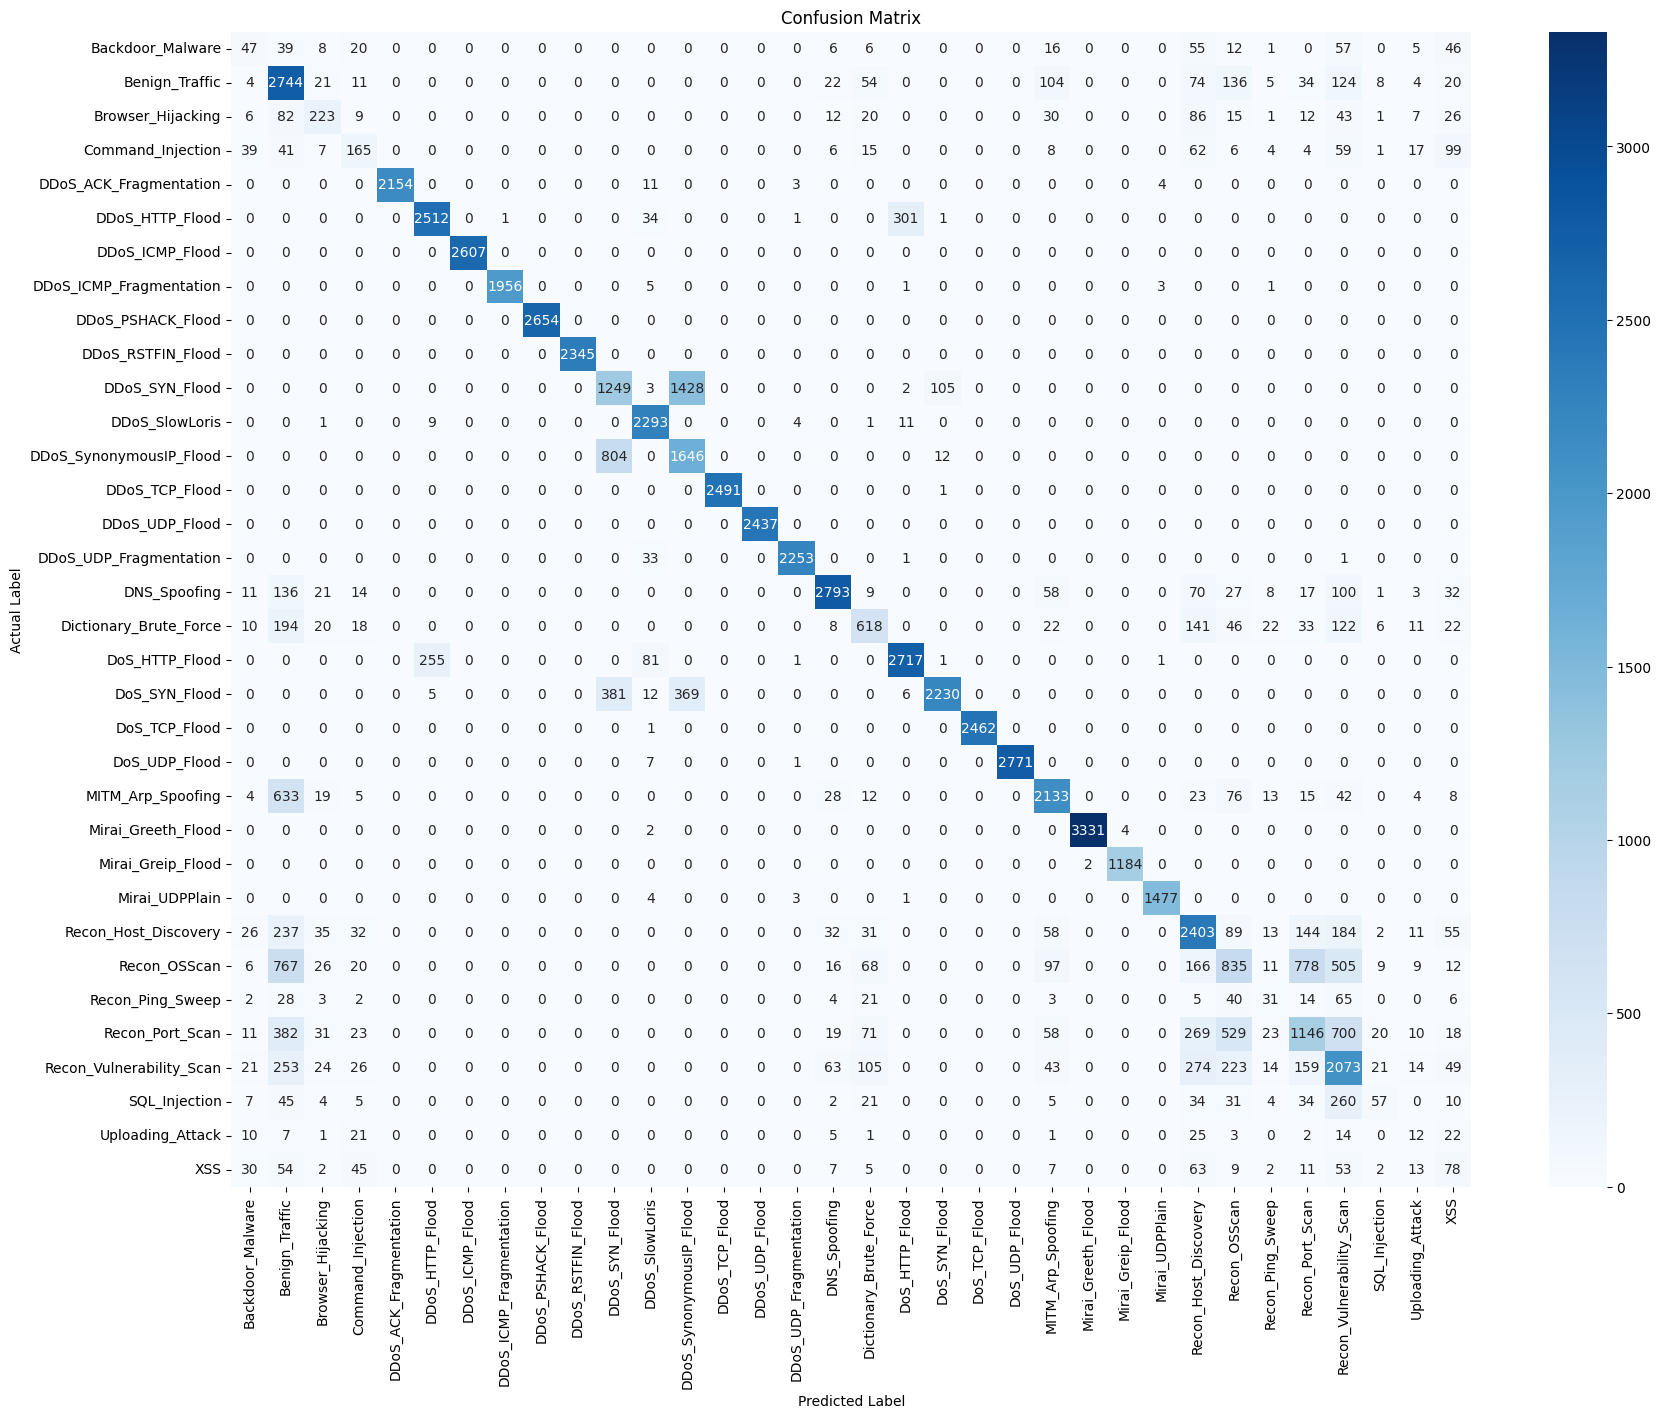

In [ ]:
# Asumsi: y_test adalah label asli dan y_pred adalah prediksi dari model Anda
cm = confusion_matrix(y_test, y_pred)

# Untuk visualisasi yang lebih baik, kita ubah menjadi DataFrame
# Pastikan Anda memiliki list nama kelas dalam urutan yang benar
class_names = final_model.classes_
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Buat heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()